In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sopt.examples.utils import NearFieldPtychographySimulation
from sopt.examples.tensorflow.near_field_ptychography.tfPtycho import AdamPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

In [2]:
%load_ext autoreload
%autoreload 2

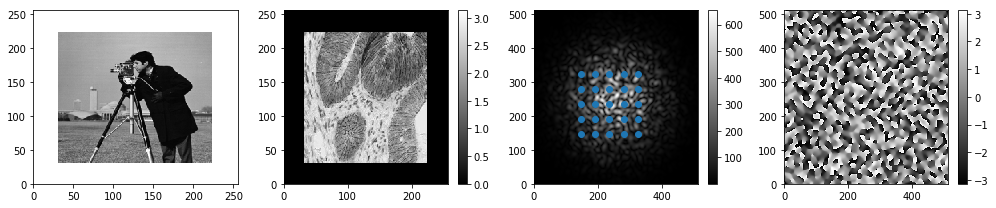

In [7]:
ptsim = NearFieldPtychographySimulation(positions_step_npix=44, probe_args={'photons_flux':1e4})

obj_center_positions = ptsim._positions + ptsim._obj_params.padded_npix // 2

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
axs[2].scatter(x=obj_center_positions.T[1], y=obj_center_positions.T[0])
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax1, ax=axs[1])
plt.colorbar(cax2, ax=axs[2])
plt.colorbar(cax3, ax=axs[3])
plt.tight_layout()
plt.show()

## Adam - reconstructing the object only

In [4]:
def runAdam(learning_rate_obj):
    pr = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=2)
    pr.setOptimizingParams(learning_rate_obj=learning_rate_obj)
    pr.initSession()
    pr.run(debug_output_epoch_frequency=100, improvement_threshold=1e-4)
    return pr.data.copy()

In [74]:
grid_obj = np.logspace(-2, 0, 3)
grid_data = {}
for lo in grid_obj:
    print(lo)
    run_data = runAdam(lo)
    grid_data[lo] = run_data.copy()
    print('Final', run_data.tail(n=1))

0.01


100  3975825 0.4315407      150  1032953  1059386
200 888384.4 0.302006      300   177177 179093.9
300 596882.3 0.2407622      450 101860.5   102137
400 523754.4  0.20412      600  84589.5 84685.26
500   499244 0.1810381      750 78475.77 78513.64
600   489112 0.164081      900 75875.25 75892.95
700 484166.7 0.1499771     1050 74557.52 74567.37
800 481316.3 0.1373832   1141.5 73770.02 73776.38
900 479428.9 0.1257152   1141.5 73230.88  73235.5
1000 478047.5 0.1147005   1141.5 72822.92 72826.55
1100 476967.8 0.1042159   1141.5 72493.88 72496.88
Final             loss   epoch  obj_error  probe_error  validation_loss  patience
1142  476578.125  1142.0   0.099958          NaN     72372.773438    1141.5
0.1


100 521247.4 0.164334      150 82065.84  82313.6
200 475452.2 0.08533084      300 71606.73 71618.66
300 472990.8 0.04125935    358.5 70960.37 70963.47
Final             loss  epoch  obj_error  probe_error  validation_loss  patience
359  472519.0625  359.0   0.025962          NaN     70840.859375     358.5
1.0


100  2790844 0.8357138      150 468698.4 473875.8
200  1594680 0.6837068    289.5 307806.8 306821.8
300  1439490 0.6063103      309 312533.6 306659.7
400  1265955 0.5746714      519   283632 283514.7
500  1022350 0.4571818      708 214472.6 212440.6
600  1030385 0.439616      708 220089.8 212440.6
700  1147964 0.4389096      708 240425.7 212440.6
Final           loss  epoch  obj_error  probe_error  validation_loss  patience
708  1219799.0  708.0   0.438321          NaN     249676.65625     708.0


In [28]:
# Not selecting 1.0 because that sometimes gets stuck in local minima.
pr = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=2)
pr.setOptimizingParams(learning_rate_obj=0.1)
pr.initSession()

Tensor("validation/stack:0", shape=(2, 512, 512), dtype=complex64)
Tensor("stack:0", shape=(23, 512, 512), dtype=complex64)


In [41]:
# Not selecting 1.0 because that sometimes gets stuck in local minima.
pr = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=2)
pr.setOptimizingParams(learning_rate_obj=0.1)
pr.initSession()

Tensor("validation/mul:0", shape=(2, 512, 512), dtype=complex64)
Tensor("mul:0", shape=(23, 512, 512), dtype=complex64)


In [42]:
%%time
pr.run(debug_output_epoch_frequency=100, improvement_threshold=1e-4)
print(pr.data.tail(n=2))

100  1612446 0.1732893      150 275487.4 279805.9
200 844469.4 0.0903693      300 77727.48 77847.54
300 791003.1 0.04244021      450 71157.83 71189.29
400   777921 0.01703631    598.5 69584.61 69588.11
500 775676.6 0.00612753      609 69320.53 69319.58
600 775417.9 0.002848359      609 69288.92 69287.98
          loss  epoch  obj_error  probe_error  validation_loss  patience
608  775405.25  608.0   0.002761          NaN     69289.187500     609.0
609  775407.75  609.0   0.002750          NaN     69288.945312     609.0
CPU times: user 10min 9s, sys: 7.06 s, total: 10min 16s
Wall time: 34 s


In [26]:
%%time
pr.run(debug_output_epoch_frequency=100, improvement_threshold=1e-4)
print(pr.data.tail(n=2))

100  1127935 0.1725348      150 108648.2 109790.7
200 851153.9 0.09453588      300 78321.94 78439.11
300 793817.4 0.04621943      450  71361.1 71396.77
400 778482.2 0.01939257      600 69501.17 69509.23
500 775606.4 0.007197121    658.5 69156.89 69156.91
600   775234 0.00309023    658.5 69113.97 69113.12
           loss  epoch  obj_error  probe_error  validation_loss  patience
658  775226.500  658.0   0.002516          NaN     69113.398438     658.5
659  775230.875  659.0   0.002511          NaN     69112.718750     658.5
CPU times: user 15min 21s, sys: 22.1 s, total: 15min 43s
Wall time: 48.1 s


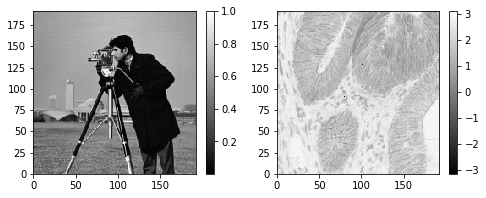

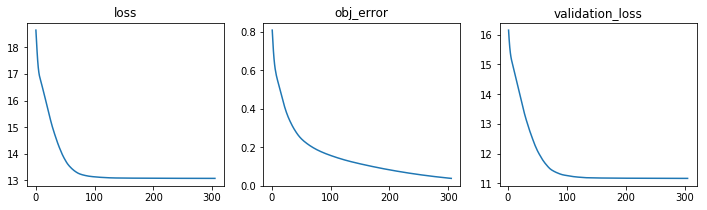

In [81]:
pr.genPlotsRecons()
pr.genPlotMetrics()

In [82]:
with pr.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops = flops.total_float_ops
    print(flops)

graph_def = pr.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr.graph, nodes_validation)
print(flops_validation)

total_flops = (flops - flops_validation) * pr.data.index[-1]
print(f'total flops {total_flops:4.3g}')

2227596487
118620160
total flops 6.43e+11


## Smaller batch size

In [71]:
def runAdamBatched(learning_rate_obj):
    pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, batch_size=5, validation_ndiffs=2)
    pr_adam.setOptimizingParams(learning_rate_obj=learning_rate_obj)
    pr_adam.initSession()
    pr_adam.run(debug_output_epoch_frequency=200, improvement_threshold=1e-4)
    return pr_adam.data.copy()

In [72]:
grid_obj = np.logspace(-2, 0, 3)
grid_data = {}
for lo in grid_obj:
    print(lo)
    run_data = runAdamBatched(lo)
    grid_data[lo] = run_data.copy()
    print('Final', run_data.tail(n=1))

0.01


200 226655.7 0.2619555      300 96500.98 96793.88
400 177738.6 0.1816374      600 75208.11 75234.57
600 171692.8 0.1367706    898.5 72635.54 72637.05
800 170271.8 0.09929001     1194 71748.85 71747.37
1000   169405 0.06737714     1494 71287.22 71288.91
1200 169051.9 0.04221549   1795.5 71045.58 71022.04
1400 169307.5 0.02483063   2053.5  70985.7 70928.62
1600 168444.1 0.01512247   2317.5 70928.45  70893.9
1800 170685.7 0.01164809   2317.5 70998.67  70893.9
2000 169822.5 0.01105721   2317.5 71000.56  70893.9
2200   171055 0.01127782   2317.5 71125.36  70893.9
Final              loss   epoch  obj_error  probe_error  validation_loss  patience
4636  170213.4375  2318.0   0.011025          NaN     71039.203125    2317.5
0.1


200 517402.4 0.06270744    211.5 120982.8 73880.28
Final             loss  epoch  obj_error  probe_error  validation_loss  patience
424  340175.6875  212.0   0.075991          NaN     185946.59375     211.5
1.0


Final           loss  epoch  obj_error  probe_error  validation_loss  patience
148  8844362.0   74.0   0.729903          NaN        7649630.0      73.5


In [83]:
pr = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, batch_size=5, validation_ndiffs=2)
pr.setOptimizingParams(learning_rate_obj=0.01)
pr.initSession()
pr.run(debug_output_epoch_frequency=200, improvement_threshold=1e-4)
print(pr.data.tail(n=2))

200 223365.4 0.2520996      300 96382.88 96864.05
400 175820.4 0.1727147      600 73514.38 73533.25
600 171777.3 0.1311324    895.5 71708.91  71713.6
800 170784.8 0.09665744   1195.5 71164.09  71156.2
1000 168922.7 0.06694695     1458 70896.26 70888.29
1200 169479.8 0.04307494     1761 70768.31 70755.34
1400 169228.6 0.02595945   2065.5 70701.35 70680.28
1600 169370.4 0.01589323   2065.5 70698.73 70677.14
1800   169518 0.01194185   2065.5 70802.92    70674
2000 170443.7 0.01106688   2065.5 70791.12    70674
               loss   epoch  obj_error  probe_error  validation_loss  patience
4131  170611.500000  2065.0        NaN          NaN              NaN       NaN
4132  170491.890625  2066.0   0.011163          NaN     70825.984375    2065.5


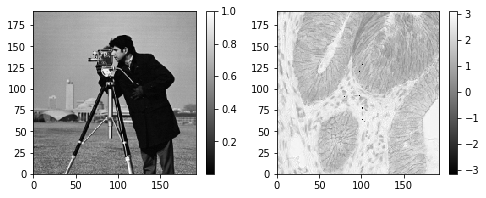

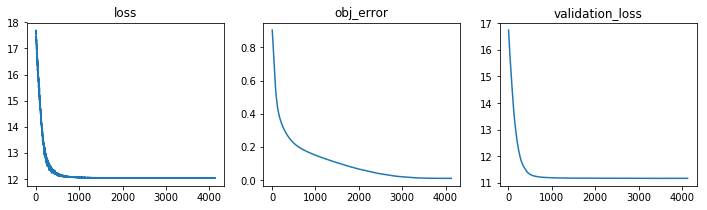

In [84]:
pr.genPlotsRecons()
pr.genPlotMetrics()

In [85]:
with pr.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops = flops.total_float_ops
    print(flops)

graph_def = pr.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr.graph, nodes_validation)
print(flops_validation)

total_flops = (flops - flops_validation) * pr.data.index[-1]
print(f'total flops {total_flops:4.3g}')


832894320
118620160
total flops 2.95e+12
